# Kaggle Titanic生存者予測 - ロジスティック回帰による検証例

KaggleのTitanicコンペを題材に，ロジスティック回帰でTintanic号の生存者を推論するPoC例を示す

このPoCをもとに，実際のAPIコードの中身を実装していく流れとなる．

NOTE:
    サンプルなので，前処理，特徴量エンジニアリングは結構適当．このノートブックは，あくまでも検証〜API化までのワークフローを自動化する際の取っ掛かり事例を示すことが目的である．

In [1]:
import pandas as pd
import  matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df_train = pd.read_csv('../.data/train.csv')

## EDA

### 基本情報

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.shape

(891, 12)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin, Embarked に欠損値あり

### 目的変数

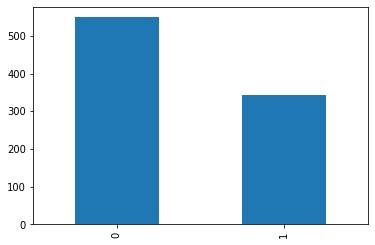

In [6]:
target = 'Survived'
df_train[target].value_counts().plot.bar()

目的変数のバイナリ値に大幅な偏りはないので，不均衡問題をあまり気にする必要はない

揃えたかったら，upsamplingなりdownsamplingなりすれば良い

### 量的変数

In [7]:
cols_quantitative= ['Age', 'SibSp', 'Parch', 'Fare']
df_train[cols_quantitative].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


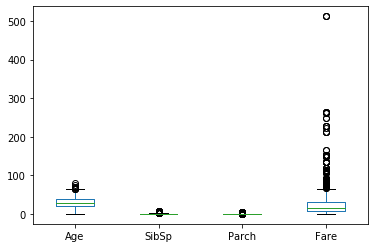

In [8]:
df_train[cols_quantitative].plot.box()

In [9]:
# スタージェスの公式 でとりあえずbin数を決める
n_bins = 1+int(np.log2(df_train.shape[0]))

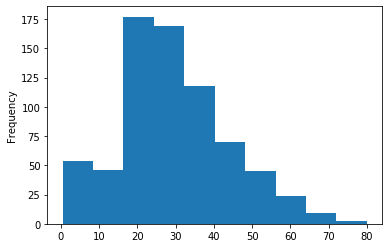

In [10]:
df_train['Age'].plot.hist(bins=n_bins)

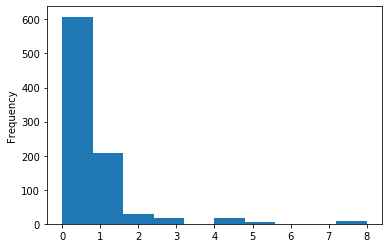

In [11]:
df_train['SibSp'].plot.hist(bins=n_bins)

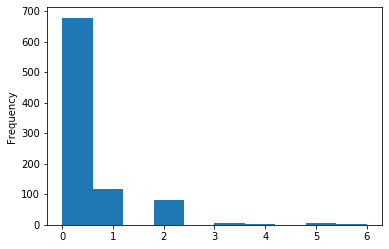

In [12]:
df_train['Parch'].plot.hist(bins=n_bins)

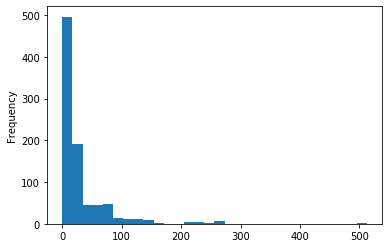

In [13]:
df_train['Fare'].plot.hist(bins=30)

**量的変数まとめ**

- 年齢 Age
    - 20,30題を中心に右に歪んだ（右裾が長い）分布．正規分布からかけ離れているわけではないので，スケールに敏感なモデルでもそこまで気にしなくてよさそう
- タイタニック号に乗っている各客の連れ（家族関係）に関する指標（比）
    - SibSp 兄弟姉妹の数/配偶者の数
        - 裾が重く， 0-1に集中
    - Parch 親の数 / 子供の数
        - 裾が重く， 0-1に集中
- 運賃 Fare
    - 特に裾が重く，0近くに集中
    
今回はロジスティック回帰を用いるので，`SibSp`, `Parch`, `Fare`を説明変数に用いる場合は変換，スケーリングを行ったほうが良さそうに見える

### 質的変数

Nameは非構造データ→今回は扱わない

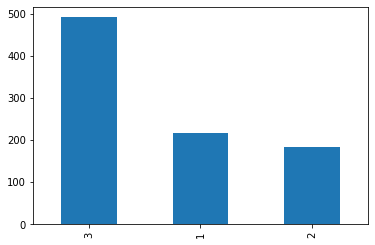

In [14]:
# クラス（階級）を表現する順序尺度
df_train['Pclass'].value_counts().plot.bar()

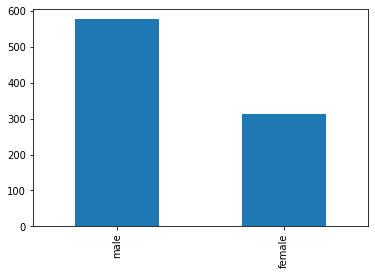

In [15]:
df_train['Sex'].value_counts().plot.bar()

In [16]:
len(df_train['Ticket'].unique())  # チケットは多カテゴリ

681

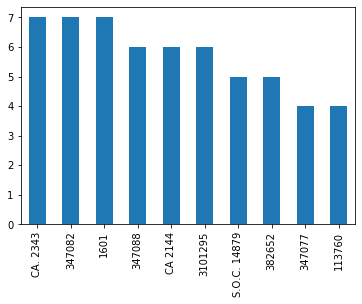

In [17]:
# 上位10カテゴリ
df_train['Ticket'].value_counts()[:10].plot.bar()

チケットのカウント数は本人＋付添の家族数を表す？

→ 実は量的変数として扱う方が都合が良い？

In [18]:
len(df_train['Cabin'].unique())

148

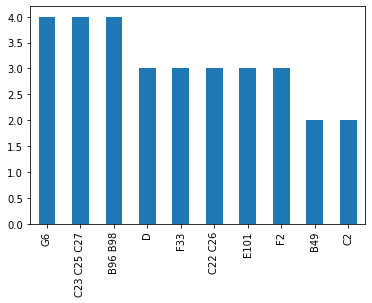

In [19]:
df_train['Cabin'].value_counts()[:10].plot.bar()

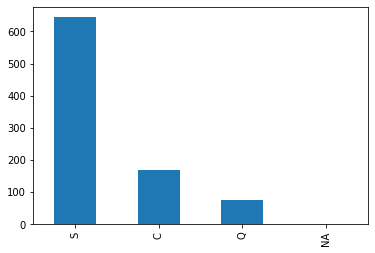

In [20]:
df_train['Embarked'].fillna('NA').value_counts().plot.bar()

## Feature Engineering

### Fillna

In [21]:
cols_quantitative

['Age', 'SibSp', 'Parch', 'Fare']

In [22]:
# Quantitative
# To median
for col in cols_quantitative:
    how = df_train[col].median()
    df_train[col] = df_train[col].fillna(how)

In [23]:
# Categorical
df_train['Embarked'] = df_train['Embarked'].fillna('NA')
df_train['Cabin'] = df_train['Cabin'].fillna('NA')

In [24]:
# 欠損が埋まっているか確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Encoding

In [25]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [26]:
cols_categ = ['Sex', 'Embarked']
cols_to_count = ['Ticket', 'Cabin']

#### Dummy Coding

In [27]:
dummy_coded = pd.get_dummies(df_train[cols_categ])
new_cols = dummy_coded.columns
df_train[new_cols] = dummy_coded

#### Count Feature

In [28]:
# reset_index()でDataFrame化でき，joinがしやすくなる
for col in cols_to_count:
    tmp_counts = df_train[col].value_counts().reset_index()
    tmp_counts.columns = [col, f'{col}_count']
    df_train = pd.merge(df_train, tmp_counts, on=col, how='left')

### Log Transform

`Fare`, `Cabin_count` が裾が重いのでこちらを対象に対数変換して，ガウス分布に近づける

#### Before

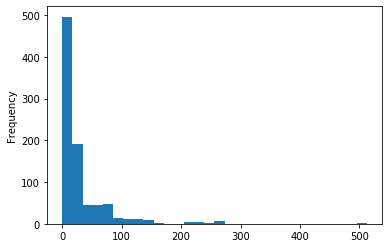

In [29]:
df_train['Fare'].plot.hist(bins=30)

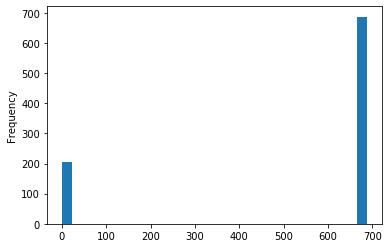

In [30]:
df_train['Cabin_count'].plot.hist(bins=30)

#### Transformation

In [31]:
import numpy as np

cols_to_transform = ['Fare', 'Cabin_count']
for col in cols_to_transform:
    df_train[col] = df_train[col].apply(np.log1p)

#### After 

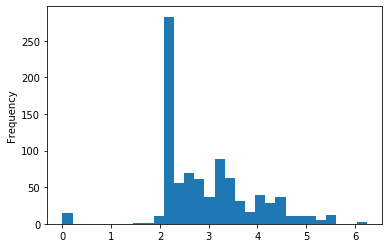

In [32]:
df_train['Fare'].plot.hist(bins=30)

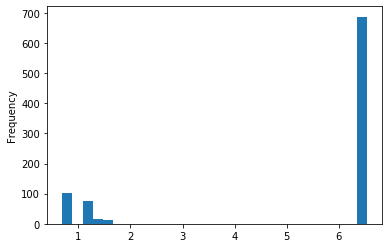

In [33]:
df_train['Cabin_count'].plot.hist(bins=30)

### Scaling

本サンプルEDAでは，ロジスティック回帰を用いるため，スケーリングは必須
→量的変数にmin-maxスケーリングを適用する

In [34]:
counts = [f'{col}_count' for col in cols_to_count]

cols_quantitative += counts
cols_quantitative

['Age', 'SibSp', 'Parch', 'Fare', 'Ticket_count', 'Cabin_count']

In [35]:
import sklearn.preprocessing as preproc
import warnings
warnings.filterwarnings('ignore')

df_train[cols_quantitative] = df_train[cols_quantitative].apply(preproc.minmax_scale)

In [36]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_NA,Embarked_Q,Embarked_S,Ticket_count,Cabin_count
0,1,0,3,"Braund, Mr. Owen Harris",male,0.271174,0.125,0.0,A/5 21171,0.338125,NA,S,0,1,0,0,0,1,0.000000,1.000000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.472229,0.125,0.0,PC 17599,0.685892,C85,C,1,0,1,0,0,0,0.000000,0.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,0.321438,0.000,0.0,STON/O2. 3101282,0.350727,NA,S,1,0,0,0,0,1,0.000000,1.000000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.434531,0.125,0.0,113803,0.639463,C123,S,1,0,0,0,0,1,0.166667,0.069421
4,5,0,3,"Allen, Mr. William Henry",male,0.434531,0.000,0.0,373450,0.352955,NA,S,0,1,0,0,0,1,0.000000,1.000000


### Feature Selection

これまで作成してきた特徴量について，大雑把に
- **量的変数** `Survived`に対して相関のありそうなものを説明変数として利用
- **質的変数** そのまま利用

する方針を立てる

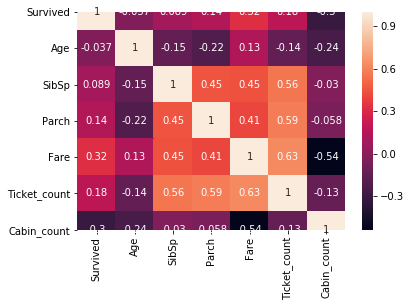

In [37]:
import seaborn as sns
corr_mat = df_train[['Survived']+cols_quantitative].corr(method='spearman')
sns.heatmap(corr_mat, annot=True)

とりあえず量的変数は`Cabin_count`, `Fare`を利用
 
 （今回はロジスティック回帰を用いるため，多重共線性が気になる．
 両者間の相関係数は`-0.54`なので，多重共線性が発生しているかもしれないが面倒なので深堀りはせず両者説明変数として考慮する．）

In [38]:
# 最終的に選定した説明変数
cols_explanatory = ['Cabin_count', 'Fare', 'Pclass', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_NA', 'Embarked_Q', 'Embarked_S']

## Training 

### Dataset preparation

In [39]:
X = df_train[cols_explanatory].values
y = df_train['Survived'].values

### Cross Validation

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

"""[設定について]

<ロジスティック回帰>
- random_state 実験の再現性をもたせるために，適当なシード値で固定
- solver 準Newton法はLBFGSが無難そうなのでチョイス
- class_weight 目的変数のクラス不均衡を自動補正
- n_jobs 使用CPUコア数を最大に

<交差検証>
train.csvから学習用と検証用に分割するが，
その際データを５分割して学習用:検証用=4:1で全組み合わせに対して学習・評価を実行
- cv とりあえず適当に5
- return_train_score Undersampling/Oversampling度合いを見たいのでTrue
"""
clf = LogisticRegression(random_state=0,
                                          solver='lbfgs',
                                          class_weight='balanced',
                                          n_jobs=-1)
scores = cross_validate(clf, X, y, cv=5, return_train_score=True)

In [41]:
train_scores = scores['train_score']
valid_scores = scores['test_score']
print("Train scores: ", train_scores)
print("Valid scores: ", valid_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (valid_scores.mean(), valid_scores.std() * 2))

Train scores:  [0.76966292 0.75983146 0.7657784  0.76437588 0.76330532]
Valid scores:  [0.73184358 0.74301676 0.75280899 0.7752809  0.78531073]
Accuracy: 0.76 (+/- 0.04)


[Kaggleの評価指標](https://www.kaggle.com/c/titanic/overview/evaluation)より，正解率で結果を出した．

当たらずとも遠からず．適当に特徴量を作った割には（学習データのvalidationレベルでは）そこそこ高く出たという感触．

（今回は，Leaderboardのスコアは出していない．）

## Conclusion

本ノートブックにおいて，前処理・特徴エンジニアリング手法でBaselineレベルのモデルが構築出来たことを確認

TODO:
    リソース管理，前処理，特徴エンジニアリング，学習，推論等，本ノートブックの手法をもとにした一通りの機械学習パイプラインをAPIとして提供可能な実装に落とし込む．